## Dependencies

```
3e4803b899e4ce11e57640598fa0276234c0891c  ../data/xianzai_phones_loglik.csv
e7714cc6f816f2c65ef3046f38f5bfacaf67e0d4  ../data/xianzai_feats.csv
```

In [1]:
phones_df_path = "../data/xianzai_phones_loglik.csv"
feats_df_path = "../data/xianzai_feats.csv"
!sha1sum $phones_df_path $feats_df_path

3e4803b899e4ce11e57640598fa0276234c0891c  ../data/xianzai_phones_loglik.csv
e7714cc6f816f2c65ef3046f38f5bfacaf67e0d4  ../data/xianzai_feats.csv


## Load Data

In [2]:
import pandas as pd
WORD = "現在"
phones_df = pd.read_csv(phones_df_path)
feats_df = pd.read_csv(feats_df_path)

In [3]:
phones_df.head()

,utt_id,t,phone,ml_phone,sil,spn,a,aj,aw,o,...,ts,tsʰ,ɕ,z,z̩,s,ŋ,ŋ̍,ɻ,ʔ
0,LJH_GY_1479,0,ɕ,io,-5.654958,-8.466764,-10.229684,-10.494264,-8.154977,-8.987256,...,-2.439233,-4.139726,-4.422456,-6.327096,-4.381189,-3.193784,-6.034997,-6.034997,-12.162404,-6.784951
1,LJH_GY_1479,1,ɕ,io,-5.640774,-9.713959,-10.250855,-8.694474,-7.724034,-7.621583,...,-3.508435,-4.342263,-5.465355,-7.665314,-5.719403,-4.722371,-6.968018,-6.968018,-13.695195,-10.121003
2,LJH_GY_1479,2,ɕ,io,-6.256535,-10.400452,-6.648217,-9.695504,-8.228860,-4.920113,...,-4.423055,-4.231938,-6.034478,-7.264245,-5.318337,-4.593133,-6.557813,-6.557813,-12.512582,-12.305062
3,LJH_GY_1479,3,ɕ,io,-8.381605,-8.974776,-7.427946,-6.121271,-11.374426,-4.007448,...,-3.754893,-4.459528,-4.320975,-6.763808,-4.817900,-3.952643,-7.416388,-7.416388,-10.864325,-11.783835
4,LJH_GY_1479,4,ɕ,t,-6.556403,-7.870498,-9.598616,-12.383986,-15.661521,-8.865058,...,-2.917655,-2.563380,-4.719085,-5.572474,-3.626567,-2.944510,-10.308570,-10.308570,-10.022887,-8.594962


In [31]:
import re
from typing import cast
from tqdm.auto import tqdm
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt

utt_meanP = {}
utt_phoneseq = {}
phone_base_idx = phones_df.columns.values.tolist().index("sil")
phone_table = phones_df.columns[phone_base_idx:].values

for utt_id, utt_df in tqdm(phones_df.groupby("utt_id", sort=False)):
    # utt_df = phones_df.loc[phones_df["utt_id"] == utt_id, :]
    pmat = utt_df.iloc[:, 4:].values

    phone_logPs = []
    phone_seq = []
    for phone, phone_grp in utt_df.groupby("phone", sort=False):
        phone = cast(str, phone)
        phone = re.sub("[\u02e5-\u02e9]+", "", phone)
        phone_idx = utt_df.columns.values.tolist().index(phone)
        phone_logPs.extend(utt_df.iloc[:, phone_idx].values)
        phone_seq.append(phone)
    phone_seq = "".join(phone_seq)
    utt_phoneseq.setdefault(phone_seq, []).append(utt_id)
    utt_meanP[utt_id] = logsumexp(phone_logPs) - np.log(pmat.shape[0])



  0%|          | 0/852 [00:00<?, ?it/s]

In [47]:
pron_df = pd.DataFrame.from_dict(
                      {k: len(v) for k, v in utt_phoneseq.items()}, 
                      orient="index", 
                      columns=["count"]).sort_values(by="count", ascending=False)
pron_df

,count
ɕjentsaj,521
ɕjenaj,269
ɕjenʈʂaj,48
jenaj,8
jentsaj,6


In [56]:
sorted_prons = pron_df.index.values
sorted_prons = [sorted_prons[x] for x in (0,2,1,4,3)]
sorted_prons

['ɕjentsaj', 'ɕjenʈʂaj', 'ɕjenaj', 'jentsaj', 'jenaj']

In [60]:
sorted_utts = []
for pron_x in sorted_prons[::-1]:
  sorted_utts.extend(sorted(utt_phoneseq[pron_x], 
                            key=lambda x: utt_meanP[x]))
sorted_utts = sorted_utts

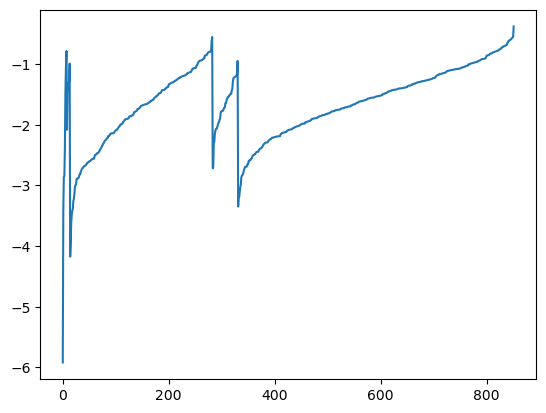

In [61]:
import matplotlib.pyplot as plt
plt.plot([utt_meanP[x] for x in sorted_utts])


In [66]:
np.median(wav)


15958

In [72]:
np.array([12.34343]).astype(np.int16)

array([12], dtype=int16)

In [80]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio

wav_dir = Path(f"~/lago/mfa_data/xianzai/s1/").expanduser()
wav_list = []
medians = []
for utt_id in sorted_utts[::25]:
  sr, wav = wavfile.read(wav_dir / f"{utt_id}.wav")
  wav_list.extend(wav)
  

In [84]:
sorted_utts[-1]

'CZX_GY_5429'

In [81]:
Audio(wav_list, rate=sr)

In [83]:
wavfile.write("../data/xianzai_stitched.wav", sr, np.array(wav_list, dtype=np.int16))